
# A point analysis of weak learning models

    Notebook version: 1.1 (Feb 2, 2017)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
               

    Changes: v.1.0 - First version

In [11]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
# import csv     # To read csv files
# import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
# from sklearn import neighbors, datasets
import wlc.WLweakener2 as wlw


## 1. Introduction.

In this notebook we analyze the behavior of sample based estimates of a $C$-dimensional probability vector $\boldsymbol{\eta}$ from binary vector instances.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of labels $\{{\bf y}_k, k=0,\ldots, K-1\}$ generated from $\boldsymbol{\eta}$, and estimates based on weak labels, $\{{\bf b}_k, k=0,\ldots, K-1\}$, generated from some related distribution ${\bf q} = {\bf M}\boldsymbol{\eta}$, where ${\bf M}$ is called a mixing matrix and contains conditional probabilities.

To do so, we will generate a dataset of labels drawn from $\boldsymbol{\eta}$, and one or more datasets of weak labels drawn from ${\bf q}$.

First we define some configurable parameters:

Mixing matrix:
[[ 0.7   0.15  0.15]
 [ 0.15  0.7   0.15]
 [ 0.15  0.15  0.7 ]]


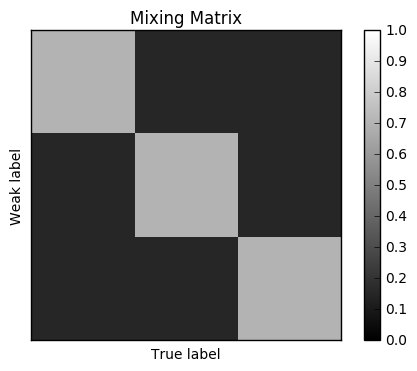

In [119]:
C = 3                             # Number of classes
K = 10000                          # Sample size
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

# Mixing matrix
# M = wlw.computeM(C, beta=0.5, method='quasi_IPL')
M = wlw.computeM(C, beta=0.3, method='noisy')
# M = M[np.sum(M, axis=1) > 0]   # This is to remove zero rows, which are not relevant

# Show:
print "Mixing matrix:"
print M
plt.imshow(M, interpolation='nearest', cmap="gray", clim=(0.0, 1.0)) 
plt.colorbar()
plt.title('Mixing Matrix')
plt.xlabel('True label')
plt.ylabel('Weak label')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### 1.1. Dataset generation.

In the following we will generate a dataset of labels and their corresponding weak labels

In [120]:
# Generate true labels
I = np.eye(C)
iy = np.random.choice(np.arange(0, C), size=K, p=eta)
y = I[iy]

# Generate weak label indices
iz = wlw.generateWeak(iy, M, C)

### 1.2. Supervised, sample based estimation.

In the supervised setting, ${\bf y}$ is observed an the optimal sample based estimate of $\boldsymbol{\eta}$ (minimizing any Bregmann divergence) based on the observed labels is the sample average

In [121]:
f = np.mean(y, axis=0)
print "Supervised estimate: {0}".format(f)
e2 = np.mean((f - eta)**2)
print "Square error: {0}".format(e2)

Supervised estimate: [ 0.5068  0.1996  0.2936]
Square error: 2.912e-05


### 1.3. Learning from weak labels.

There are many ways to estimate $\boldsymbol{\eta}$ from the weak labels. We consider here a representative sample of them:

#### 1.3.1. Averaging virtual labels

If ${\bf z}$ is a sample from distribution ${\bf q}$, and ${\bf V}$ is any left inverse of the mixing matrix (so that ${\bf V}{\bf M} = {\bf I}$ then it can be shown that $\mathbb{E}\{{\bf v}\} = \boldsymbol{\eta}$. Therefore, we can estimate $\boldsymbol{\eta}$ as the average of virtual labels:

In [122]:
# v = wlw.computeVirtual(iz, C, method='quasi_IPL')
v = wlw.computeVirtual(iz, C, M=M, method='Mproper')
print "Virtual labels are:"
print v
f_v = np.mean(v, axis=0)

print "Virtual label estimate: {0}".format(f_v)
e2 = np.mean((f_v - eta)**2)
print "Square error: {0}".format(e2)

Virtual labels are:
[[ 1.54545455 -0.27272727 -0.27272727]
 [ 1.54545455 -0.27272727 -0.27272727]
 [ 1.54545455 -0.27272727 -0.27272727]
 ..., 
 [-0.27272727  1.54545455 -0.27272727]
 [ 1.54545455 -0.27272727 -0.27272727]
 [ 1.54545455 -0.27272727 -0.27272727]]
Virtual label estimate: [ 0.51181818  0.19472727  0.29345455]
Square error: 7.01046831959e-05


#### 1.3.2. Maximum Likelihood Estimate

The ML estimate cannot be computed analytically, but we can apply expectation maximization. We will first define a function to compute the ML estimate recursively, and another function to compute the negative log-likelihood funtion that this estimate maximizes.

In [123]:
def computeML(iz, M, f0=None, max_iter=1e10, echo='off'):
    """
    Compute the ML estimate of a probability vector based on weak labels in iz and the mixing matrix M.
    The estimation method is based on Expectation Maximization.
    """

    # Initialize the estimate.
    if f0 is None:
        C = M.shape[1]   # No. of classes
        f_ml = np.ones(C)/C
    else:
        f_ml = f0

    # Recursive estimation
    iterate = True
    count = 0
    while iterate:
        fi = np.dot(np.diag(f_ml), M.T)[:,iz.astype(int)]
        fi = fi / np.sum(fi, axis=0)
        f_new = np.mean(fi, axis=1)
        count += 1
        iterate = np.any(f_new != f_ml) and count < max_iter
        f_ml = np.copy(f_new)
    
    if echo=='on':
        if count>= max_iter:
            print "Stopped before convergence after {0} iterations".format(max_iter)
        else:
            print "Converged in {0} iterations".format(count)

    return f_ml

def computeNLL(iz, M, f):
    """
    Compute the Log-Likelihood function for an estimate f.
    """
    NLL = - np.mean(np.log(np.dot(M[iz.astype(int)], f)))

    return NLL


We can verify that the EM steps monotonically increase the NLL

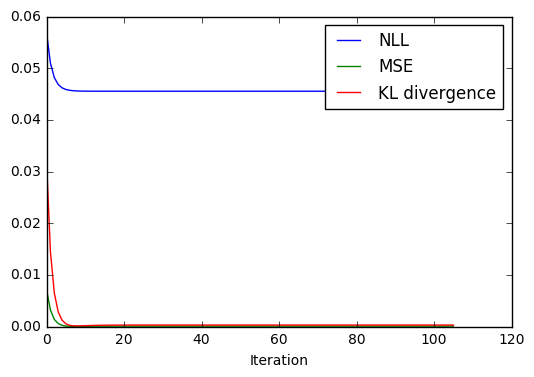

The final estimate is [ 0.51181818  0.19472727  0.29345455]
The true label is [ 0.5  0.2  0.3]


In [127]:
n_it = 1000

f = None
NLL = []
MSE = []
KL = []

for i in range(n_it):
    
    f_new = computeML(iz, M, f, max_iter=1)
    
    if f is not None and np.all(f_new == f):
        break
    else:
        f = np.copy(f_new)

    NLL.append(computeNLL(iz, M, f) + np.dot(eta, np.log(eta)))
    MSE.append(np.mean((f - eta)**2))
    KL.append(- np.dot(eta, np.log(f)) + np.dot(eta, np.log(eta)))

its = range(len(NLL))
plt.plot(its, NLL, label= "NLL")
plt.plot(its, MSE, label= "MSE")
plt.plot(its, KL, label= "KL divergence")
plt.legend()
plt.xlabel('Iteration')
plt.show()
print "The final estimate is {0}".format(f)
print "The true label is {0}".format(eta)


In [112]:
f_ml = computeML(iz, M, max_iter=100000, echo='on')

print "ML estimate: {0}".format(f_ml)
e2 = np.mean((f_ml - eta)**2)
print "Square error: {0}".format(e2)

Converged in 133 iterations
ML estimate: [ 0.56        0.14545455  0.29454545]
Square error: 0.00220165289256


## 2. Statistical analysis of the MSE.

We will compute all estimates multiple times in order to compare the distribution of the MSE.

First, to make sure that the WLL estimate is working properly, we plot the convergence of the estimate with the number of iterations

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

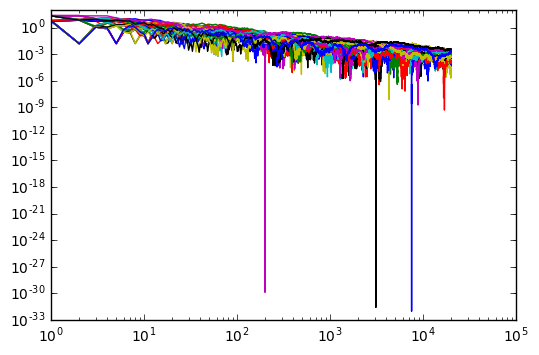

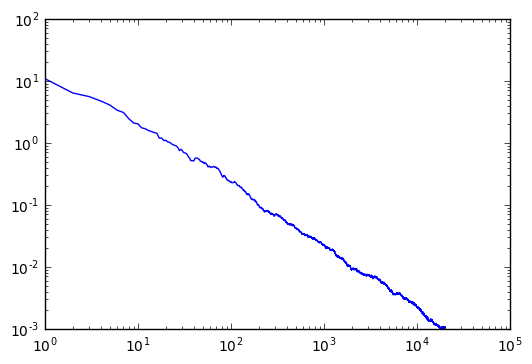

In [62]:
n_sim = 50
mse = {'wll': []}
K = 20000
for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print str(n+1),
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)
    # Estimation with virtual labels
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.cumsum(v, axis=0) / np.arange(1, K+1)[:,np.newaxis]

    mse_n = np.mean((f_v - eta)**2, axis=1)
    mse['wll'].append(mse_n)

plt.loglog(np.array(mse['wll']).T)
plt.show()
plt.loglog(np.mean(np.array(mse['wll']), axis=0))
plt.show()



In [63]:
n_sim = 100
mse = {'sup': [], 'wll': [], 'wml': []}

for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print str(n+1),
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)
    mse['sup'].append(np.sum((f - eta)**2))

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    mse['wll'].append(np.mean((f_v - eta)**2))

    # ML estimate
    f_ml = computeML(iz, M, max_iter=1000)
    mse['wml'].append(np.sum((f_ml - eta)**2))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79

KeyboardInterrupt: 

ValueError: x and y must be the same size

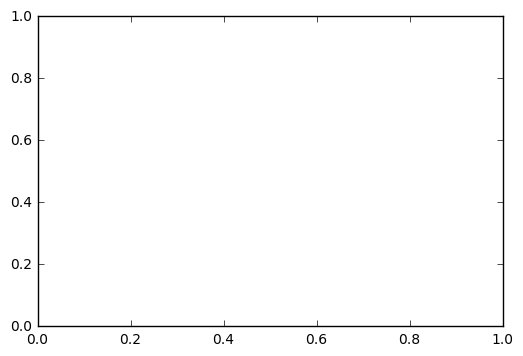

In [64]:
tag_list = ['sup', 'wll', 'wml']
for i, tag in enumerate(tag_list):
    plt.scatter([i + 1]*n_sim, mse[tag], c=[i]*n_sim, s=10, cmap='copper')

plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.axis('tight')
plt.ylim((0,0.01))
plt.show(block=False)

plt.boxplot([mse[tag] for tag in tag_list])
plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.show()

In [ ]:
n_sim = 100
K = 50

mse = []
for n in range(n_sim):

    if (n+1)/1*1 == n+1:
        print str(n+1),

    # Generate fully labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weakly labeled dataset
    iy = np.random.choice(np.arange(0, C), size=50*K, p=eta)
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    
    w = np.arange(0, 1, 0.001)[:, np.newaxis]
    f_est = f * w + f_v * (1 - w)
    mse_n = np.mean((f_est - eta)**2, axis=1)
    mse.append(mse_n)

plt.plot(w.flatten(), np.array(mse).T)
plt.xlabel('w')
plt.show()

mse_mean =  np.mean(np.array(mse), axis=0)
mse_std = np.std(np.array(mse), axis=0)
plt.plot(w.flatten(), mse_mean)
plt.fill_between(w.flatten(), mse_mean - mse_std, mse_mean + mse_std,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)
plt.xlabel('w')
plt.show()
